# Session 7 further work

In [1]:
# We always start with appropriate imports; note the use of the IPython magic
# command to set up Matplotlib within the notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 4. Small  particles

### Question 1

In [2]:
Nstep = 200
# Storage
r = np.zeros([Nstep,3])
v = np.zeros([Nstep,3])
a = np.zeros([Nstep,3])
# t=0
r[0] = np.array([1.0,0.0,0.0])
v[0] = np.array([0.0,1.0,0.1])
a[0] = np.array([-1.0,0.0,0.0])
# Timestep
dt = 0.1
# Velocity Verlet algorithm
for i in range(1,Nstep):
    t = i*dt
    a[i] = np.array([-np.cos(t),-np.sin(t),0.0])
    r[i] = r[i-1] + dt*v[i-1] + 0.5*dt*dt*a[i-1]
    v[i] = v[i-1] + 0.5*dt*(a[i] + a[i-1])

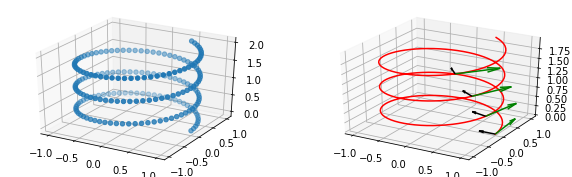

In [3]:
fig_3d2 = plt.figure(figsize=(10,3))
ax3d2a = fig_3d2.add_subplot(121,projection='3d')
ax3d2a.scatter(r[:,0],r[:,1],r[:,2])
ax3d2b = fig_3d2.add_subplot(122,projection='3d')
ax3d2b.plot(r[:,0],r[:,1],r[:,2],color='r')
step = 60
ax3d2b.quiver(r[::step,0],r[::step,1],r[::step,2],
              v[::step,0],v[::step,1],v[::step,2],length=0.7,color='g')
ax3d2b.quiver(r[::step,0],r[::step,1],r[::step,2],
              a[::step,0],a[::step,1],a[::step,2],length=0.3,color='k')

### Question 2

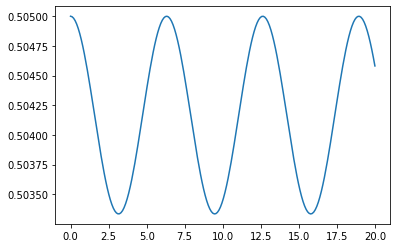

In [4]:
ke = 0.5*np.sum(v*v,axis=1)
plt.plot(np.linspace(0,dt*Nstep,Nstep),ke)

This is well-conserved - the deviation is 0.2% over 200 steps.  Decreasing the timestep to 0.01 improves the conservation by a factor of 100.  This agrees with the analysis that the velocity Verlet algorithm is accurate for velocity to $\Delta t^2$.

### Question 3

In [5]:
def hardwall(r,v,boxlen):
    """Implements hard-wall boundary conditions for a particle"""
    rout = r
    vout = v
    for i in range(3):
        if r[i]>boxlen:
            rout[i] = 2*boxlen-r[i]
            vout[i] = -v[i]
        if r[i]<0.0:
            rout[i] = -r[i]
            vout[i] = -v[i]
    return rout, vout

In [6]:
boxlen = 10.0
Nstep = 200
# Storage
rbox2 = np.zeros([Nstep,3])
vbox2 = np.zeros([Nstep,3])
# t=0
rbox2[0] = boxlen*np.random.rand(3)
vbox2[0] = 5*np.random.rand(3)
# Timestep
dt = 0.1
a = np.zeros(3)
# Velocity Verlet algorithm
for i in range(1,Nstep):
    t = i*dt
    rbox2[i] = rbox2[i-1] + dt*vbox2[i-1] + 0.5*dt*dt*a
    rbox2[i], vbox2[i-1] = hardwall(rbox2[i],vbox2[i-1],boxlen)
    vbox2[i] = vbox2[i-1] + 0.5*dt*(a + a)

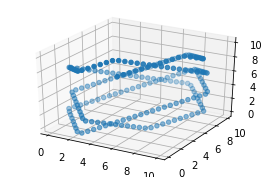

In [7]:
fig_3d3 = plt.figure(figsize=(10,3))
ax3d3a = fig_3d3.add_subplot(121,projection='3d')
ax3d3a.scatter(rbox2[:,0],rbox2[:,1],rbox2[:,2])

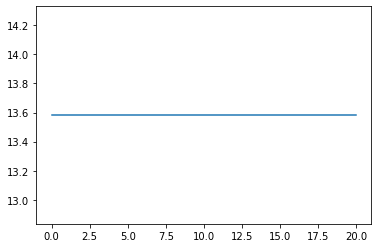

In [8]:
ke2 = 0.5*np.sum(vbox2*vbox2,axis=1)
plt.plot(np.linspace(0,dt*Nstep,Nstep),ke2)

## 5. The Lennard-Jones potential

### Question 1

In [9]:
def find_forces_LJ(pos,N,sigma,epsilon,boxlen):
    """Evaluate the force due to Lennard-Jones potential"""
    force = np.zeros((N,3))
    energy = 0.0
    sigma6 = sigma**6
    sigma12 = sigma6*sigma6
    for i in range(N-1):
        for j in range(i+1,N):
            dr = pos[j]-pos[i]
            # Ensure that we interact with the closest particle through periodic boundaries
            dr -= boxlen*np.rint(dr/boxlen)
            dr2 = np.sum(dr*dr)
            dr2i = 1.0/dr2
            dr6i = dr2i*dr2i*dr2i
            fij= 24.0*epsilon*dr*dr2i*dr6i*(sigma6 - 2.0*sigma12*dr6i)
            force[i] += fij
            force[j] -= fij
            energy += 4.0*epsilon*dr6i*(sigma12*dr6i - sigma6)
    return energy, force

In [25]:
# Initialisation
Nsteps = 5000
kB = 1.38e-23         # J/K
sigma = 0.275e-9      # 0.275nm
epsilon = 36*kB       # 36kT
mass = 20.2*1.673e-27 # kg
Ncells = 3
boxlen = Ncells*2**(1/6)*sigma
Npart = Ncells*Ncells*Ncells
rbox3 = np.zeros([Nsteps,Npart,3])
vbox3 = np.zeros([Nsteps,Npart,3])
count = 0
for i in range(Ncells):
    for j in range(Ncells):
        for k in range(Ncells):
            rbox3[0,count] = (1.0/Ncells)*boxlen*np.array([i,j,k])
            count += 1
# Initialise velocities
initT  = 300          # K
vsig = np.sqrt(kB*initT/mass)
vbox3[0] = np.random.normal(scale=vsig, size=(Npart,3))
energy = np.zeros(Nsteps)
temp = np.zeros(Nsteps)
e, f = find_forces_LJ(rbox3[0],Npart,sigma,epsilon,boxlen)
energy[0] = e
temp[0] = mass*np.sum(vbox3[0]*vbox3[0])/(3*Npart*kB)
acc = f/mass
print("Potential energy and temperature are ",e,"J ",temp[0],"K")
dt = 1e-15 # s 

Potential energy and temperature are  -6.300447499999996e-20 J  290.74944885780246 K


In [11]:
for step in range(1,Nsteps):
    rbox3[step] = rbox3[step-1] + dt*vbox3[step-1] + 0.5*dt*dt*acc # acc at step-1
    rbox3[step] = rbox3[step]%boxlen
    energy[step], f = find_forces_LJ(rbox3[step],Npart,sigma,epsilon,boxlen)
    acc_next = f/mass
    vbox3[step] = vbox3[step-1] + 0.5*dt*(acc_next + acc)
    temp[step] = mass*np.sum(vbox3[step]*vbox3[step])/(3*Npart*kB)
    acc = acc_next

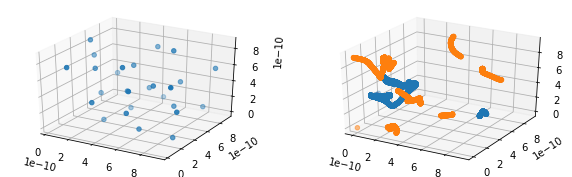

In [12]:
fig_3d6 = plt.figure(figsize=(10,3))
ax3d6a = fig_3d6.add_subplot(121,projection='3d')
step = 400
ax3d6a.scatter(rbox3[step,:,0],rbox3[step,:,1],rbox3[step,:,2])
ax3d6b = fig_3d6.add_subplot(122,projection='3d')
part = 4
ax3d6b.scatter(rbox3[:,part,0],rbox3[:,part,1],rbox3[:,part,2])
part = 0
ax3d6b.scatter(rbox3[:,part,0],rbox3[:,part,1],rbox3[:,part,2])

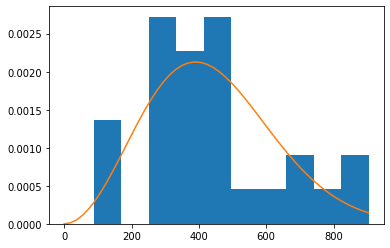

In [13]:
v2 = np.sqrt(np.sum(vbox3[Nsteps-1]*vbox3[Nsteps-1],axis=1))
plt.hist(v2,density=True)
A = np.sqrt(2/np.pi)*(mass/(kB*temp[Nsteps-1]))**1.5
vel = np.linspace(0,np.max(v2))
plt.plot(vel,A*vel*vel*np.exp(-mass*vel*vel/(2*kB*temp[Nsteps-1])))

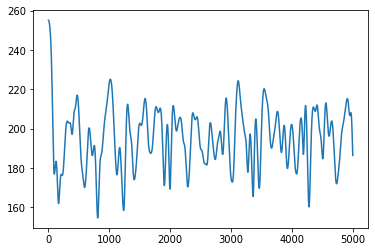

In [14]:
plt.plot(temp)

## 6. Inverse quadratic

### Question 1

In [15]:
def find_acc_grav(pos,mass,N):
    """Evaluate the acceleration due to gravity"""
    acc = np.zeros_like(pos)
    for i in range(N-1):
        for j in range(i+1,N):
            dr = pos[j]-pos[i]
            dr2 = np.sum(dr*dr)
            dri3 = 1.0/(np.sqrt(dr2)*dr2)
            acc[i] += Gconst*mass[j]*dr*dri3
            acc[j] -= Gconst*mass[i]*dr*dri3
    return acc

In [16]:
Nbody   = 3
mass = np.zeros(3)
mass[0] = 6.0e24 # kg Earth
mass[1] = 7.4e22 # kg Moon
mass[2] = 1000   # kg satellite
R_EM = 3.8e8     # m
R_ES = 4.2e7     # m
T_EM = 28*24*3600 # s
T_ES = 24*3600    # s
Gconst  = 6.7e-11 # m^3 kg^{-1} s^{-2}
omega_ES = 2*np.pi/T_ES
omega_EM = 2*np.pi/T_EM
#omega_JS = 2*np.pi/T_JS
dt = 3600 # s
Nsteps = int((50*24*3600)/dt)
pos = np.zeros((Nsteps,Nbody,3))
pos[0,0] = np.array([0.0,0.0,0.0])
pos[0,1] = np.array([R_EM,0.0,0.0])
pos[0,2] = np.array([R_ES,0.0,0.0])
vel = np.zeros((Nsteps,Nbody,3))
vel[0,0] = np.array([0.0,0.0,0.0])
vel[0,1] = np.array([0.0,R_EM*omega_EM,0.0])
vel[0,2] = np.array([0.0,0.0,R_ES*omega_ES])
acc = find_acc_grav(pos[0],mass,Nbody)

In [17]:
for step in range(1,Nsteps):
    pos[step] = pos[step-1] + dt*vel[step-1] + 0.5*dt*dt*acc
    acc_next = find_acc_grav(pos[step],mass,Nbody)
    vel[step] = vel[step-1] + 0.5*dt*(acc+acc_next)
    acc = acc_next

(-500000000.0, 500000000.0)

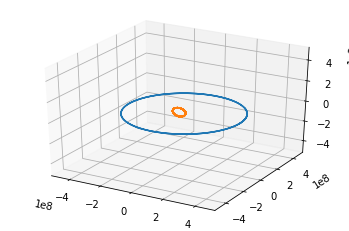

In [18]:
fig_3d1 = plt.figure()
ax3d1 = fig_3d1.add_subplot(111,projection='3d')
ax3d1.plot(pos[:,1,0]-pos[:,0,0],pos[:,1,1]-pos[:,0,1],pos[:,1,2]-pos[:,0,2])
ax3d1.plot(pos[:,2,0]-pos[:,0,0],pos[:,2,1]-pos[:,0,1],pos[:,2,2]-pos[:,0,2])
#ax3d1.axis('scaled')
ax3d1.set_xlim(-5e8,5e8)
ax3d1.set_ylim(-5e8,5e8)
ax3d1.set_zlim(-5e8,5e8)

(-46195293.03456773, 46199775.85878894, -46175870.14771947, 46182912.922382705)

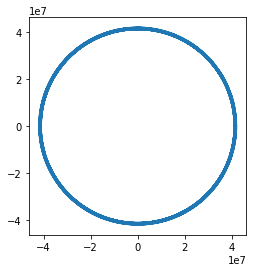

In [19]:
plt.plot(pos[:,2,0]-pos[:,0,0],pos[:,2,2]-pos[:,0,2])
plt.axis('scaled')

If we compare to the previous solution (in the Earth-Moon plane) we see that the orbits are essentially identical

## 7. Coarse graining

### Question 1

In [20]:
def int_force(pos,N):
    """Generic interaction force; exclude ends"""
    force = np.zeros_like(pos)
    for i in range(1,N-1):
        for j in (-1,1):
            dr = pos[i+j]-pos[i]
            dri2 = 1.0/np.sum(dr*dr)
            dri4 = dri2*dri2
            dri6 = dri4*dri2
            force[i] += Dconst*(2.0*dri4 - 4.0*dri6)*dr
    return force

In [21]:
Nsteps_ch = 3000
dt = 1e-3
Dconst = 1e4
Nchain = 20
pos_chain = np.zeros((Nsteps_ch,Nchain,2))
pos_chain[0,:,0] = np.sqrt(2)*np.linspace(0,Nchain-1,Nchain)
vel_chain = np.zeros((Nsteps_ch,Nchain,2))
acc_chain = int_force(pos_chain[0],Nchain) + np.array([0.0,-9.8])

In [22]:
for step in range(1,Nsteps_ch):
    pos_chain[step] = pos_chain[step-1] + dt*vel_chain[step-1] + 0.5*dt*dt*acc_chain
    pos_chain[step,0] = np.sqrt(2)*np.array([0.0,0.0])
    pos_chain[step,-1] = np.sqrt(2)*np.array([Nchain-1,0.0])
    acc_next = int_force(pos_chain[step],Nchain) + np.array([0.0,-9.8])
    vel_chain[step] = vel_chain[step-1] + 0.5*dt*(acc_chain+acc_next)
    vel_chain[step] *= 0.9995
    vel_chain[step,0]  = np.zeros(2)
    vel_chain[step,-1] = np.zeros(2)
    acc_chain = acc_next

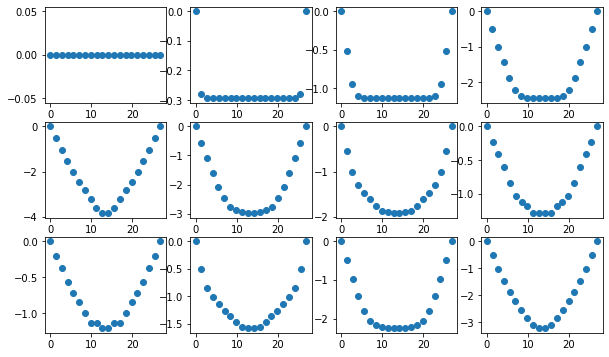

In [23]:
figS5Q4 = plt.figure(figsize=(10,6))
index = 1
for i in range(0,Nsteps_ch,250):
    ax = figS5Q4.add_subplot(3,4,index)
    ax.plot(pos_chain[i,:,0],pos_chain[i,:,1],'o')
    index += 1

Now we see the familiar catenary shape, and we see that there is no oscillation.  Making the damping too large (around 0.95) means that the chain doesn't reach the minimum - it is over-damped.  A very small value (0.9995) gives some under-damping.